In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import warnings

from joblib import Parallel, delayed

# switch off the warnings
warnings.filterwarnings("ignore")

In [3]:
df_oil = pd.read_csv('oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
df_stores = pd.read_csv('stores.csv', header = 0)
df_trans = pd.read_csv('transactions.csv', header = 0)

In [4]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

In [5]:
df_oil.head()

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


In [6]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.merge(df_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)

In [8]:
calendar['dofw'] = calendar.index.dayofweek

In [10]:
df_holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)

df_holidays['date'] = df_holidays['date'].replace({'2013-04-29' :
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction
df_holidays = df_holidays.set_index('date').sort_index()

df_holidays = df_holidays[df_holidays.locale == 'National'] # National level only for simplicity

df_holidays = df_holidays.groupby(df_holidays.index).first() # Keep one event only

In [11]:
calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_holidays, how='left', left_index=True, right_index=True)
calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

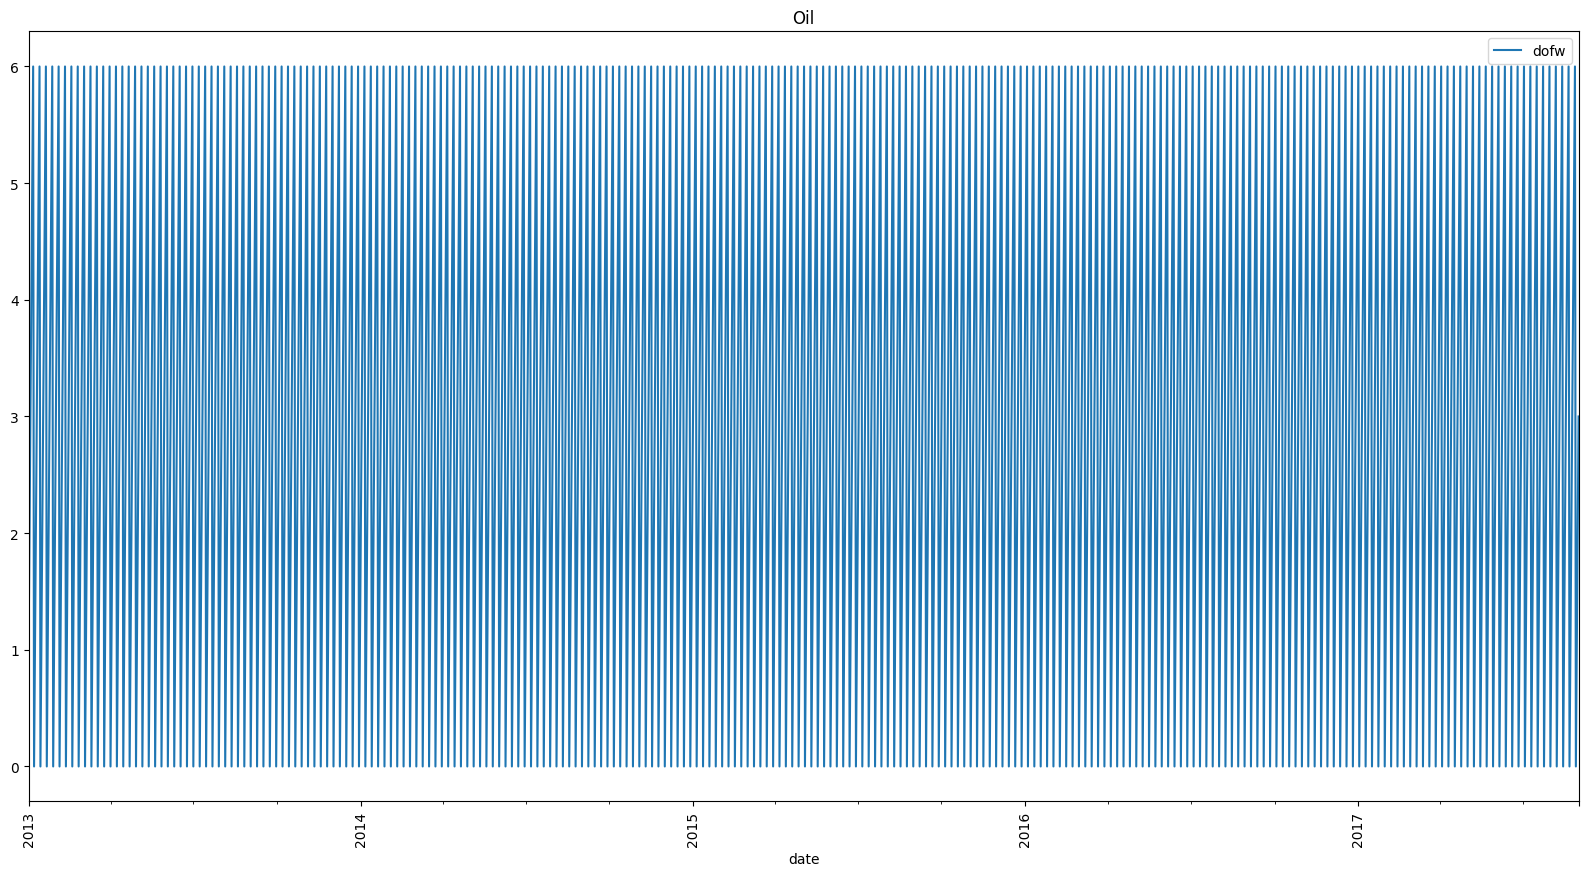

In [12]:
calendar.plot(figsize=(20,10), title= "Oil", xlabel= "date", rot=90);

In [14]:
df_train = pd.read_csv('train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

In [15]:
df_train.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [16]:
df_test = pd.read_csv('test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [17]:
df_test.head()

Empty DataFrame
Columns: []
Index: [(1, AUTOMOTIVE, 2017-08-16), (1, AUTOMOTIVE, 2017-08-17), (1, AUTOMOTIVE, 2017-08-18), (1, AUTOMOTIVE, 2017-08-19), (1, AUTOMOTIVE, 2017-08-20)]

In [ ]:
sdate = '2017-04-01'
edate = '2017-08-15'

In [ ]:
y = df_train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

In [ ]:
# Extentions
X['oil']  = calendar.loc[sdate:edate]['ma_oil'].values
X['dofw'] = calendar.loc[sdate:edate]['dofw'].values
X['wd']   = calendar.loc[sdate:edate]['wd'].values
X['type'] = calendar.loc[sdate:edate]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

In [ ]:
X.head()

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",oil,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Event,type_Holiday,type_Transfer
date,,,,,,,,,,,,,,,,,,,
2017-04-01,1.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,48.570000,False,False,False,False,False,True,False,False,False,False,False
2017-04-02,2.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,48.570000,False,False,False,False,False,False,True,False,False,False,False
2017-04-03,3.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.034286,True,False,False,False,False,False,False,False,False,False,False
2017-04-04,4.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,49.561429,True,True,False,False,False,False,False,False,False,False,False
2017-04-05,5.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,50.150000,True,False,True,False,False,False,False,False,False,False,False


In [28]:
model = Ridge(fit_intercept=True, solver='auto', alpha=0.5)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [29]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0

y_target.groupby('family').apply(lambda x: mean_squared_log_error(x['sales'], x['sales_pred']))

family
AUTOMOTIVE                    0.251843
BABY CARE                     0.066481
BEAUTY                        0.258316
BEVERAGES                     0.191974
BOOKS                         0.026568
BREAD/BAKERY                  0.118986
CELEBRATION                   0.285675
CLEANING                      0.215318
DAIRY                         0.130222
DELI                          0.103148
EGGS                          0.138037
FROZEN FOODS                  0.157259
GROCERY I                     0.204466
GROCERY II                    0.341408
HARDWARE                      0.271142
HOME AND KITCHEN I            0.254312
HOME AND KITCHEN II           0.217591
HOME APPLIANCES               0.150213
HOME CARE                     0.116671
LADIESWEAR                    0.251345
LAWN AND GARDEN               0.207535
LINGERIE                      0.393154
LIQUOR,WINE,BEER              0.634385
MAGAZINES                     0.248643
MEATS                         0.113927
PERSONAL CARE     

<Axes: xlabel='date'>

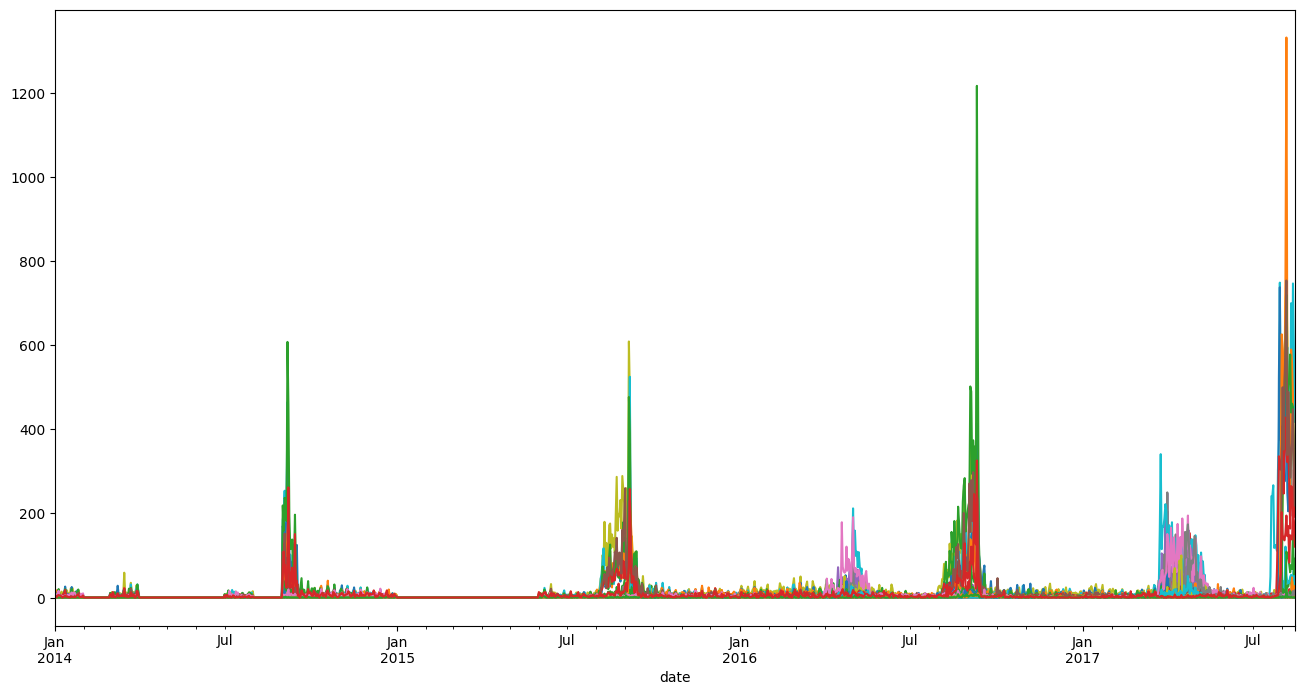

In [30]:
df_train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

In [33]:
class SalesRegressor():

    def __init__(self, n_jobs=-1, verbose=0):

        self.n_jobs = n_jobs
        self.verbose = verbose

        self.estimators_ = None

    def _estimator_(self, X, y):

        warnings.simplefilter(action='ignore', category=FutureWarning)

        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':

            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)

        else:

            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5)

        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs,
                              verbose=self.verbose,
                              )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))

        return

    def predict(self, X):

        y_pred = Parallel(n_jobs=self.n_jobs,
                          verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)

        return np.stack(y_pred, axis=1)

In [34]:
model = SalesRegressor(n_jobs=-1, verbose=0)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [35]:
# We get a prediction
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0
y_target.groupby('family').apply(lambda x: mean_squared_log_error(x['sales'], x['sales_pred']))

family
AUTOMOTIVE                    0.251843
BABY CARE                     0.066481
BEAUTY                        0.258316
BEVERAGES                     0.191974
BOOKS                         0.026568
BREAD/BAKERY                  0.118986
CELEBRATION                   0.285675
CLEANING                      0.215318
DAIRY                         0.130222
DELI                          0.103148
EGGS                          0.138037
FROZEN FOODS                  0.157259
GROCERY I                     0.204466
GROCERY II                    0.341408
HARDWARE                      0.271142
HOME AND KITCHEN I            0.254312
HOME AND KITCHEN II           0.217591
HOME APPLIANCES               0.150213
HOME CARE                     0.116671
LADIESWEAR                    0.251345
LAWN AND GARDEN               0.207535
LINGERIE                      0.393154
LIQUOR,WINE,BEER              0.634385
MAGAZINES                     0.248643
MEATS                         0.113927
PERSONAL CARE     

In [36]:
stest = '2017-08-16'
etest = '2017-08-31'
X_test = dp.out_of_sample(steps=16)

In [37]:
# Extentions
X_test['oil']  = calendar.loc[stest:etest]['ma_oil'].values
X_test['dofw'] = calendar.loc[stest:etest]['dofw'].values
X_test['wd']   = calendar.loc[stest:etest]['wd'].values
X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0
sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])
sales_pred[sales_pred < 0] = 0. # Sales should be >= 0

In [38]:
df_sub = pd.read_csv('sample_submission.csv', index_col='id')
df_sub.sales = sales_pred.values
df_sub.to_csv('output.csv')